# (sqrt) **XGBoost** 

---

## 0. Importing dependencies

In [1]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [2]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [3]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Philippines', 'Country_Saudi Arabia', 'Country_Latvia', 'Country_Mongolia', 'Country_Venezuela', 'Country_Estonia', 'Ethnicity_North American / Central American', 'Country_Jordan', 'Country_Lebanon', 'Country_Angola', 'Country_Botswana', 'Country_Cyprus', 'Country_Croatia', 'Country_Malta', 'Country_Nomadic', 'Country_Georgia', 'Country_Costa Rica', 'Country_Kenya', 'Country_El Salvador', 'Country_Yemen', 'Country_Serbia', 'Country_Andorra', 'Country_New Zealand', 'Country_Armenia', 'Country_Peru', 'Country_Kosovo', 'Country_Viet Nam', 'Country_Bosnia-Herz.', 'Country_Zimbabwe', 'Country_Bangladesh', 'Country_Sri Lanka', 'Country_Tanzania', 'Country_North Macedonia', 'Country_Slovakia', 'Country_Uzbekistan', 'Country_Paraguay', 'Country_United Arab Emirates', 'Country_Azerbaijan'}
Columns in the test set that aren't in the train set: {'Country_Qatar', 'Country_Belarus', 'Country_Republic of Korea', 'Country_Senegal', "Coun

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [4]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary",
                 "Remote_work",
                 "Certifications",
                 "Coding_as_hobby",
                 "Coding_experience",
                 "Gender"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]


# Upon exploration in MLR results, we found that the following columns are adding noise to the model
# as they correspond to values mainly from USA with non-sense relationship mainly Work_experience - Annual_salary
# Hence, we will remove them from the baseline model
baseline_train_df.drop([2153,359, 281, 297, 432, 601, 309, 239, 409, 454], inplace=True)
baseline_test_df.drop(538, inplace=True)

baseline_train_df.head()

,Education,Company_size,Age,Coding_as_hobby,Certifications,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Remote_work_hybrid,...,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Coding_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,6.6,5.0,40205.0
1,3.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,5.8,3.0,52769.0
2,2.0,1.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,6.0,5.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,7.6,6.0,72243.0
4,0.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,12.2,10.0,62820.0


In [5]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(baseline_train_df['Annual_salary'])
y_test = np.sqrt(baseline_test_df['Annual_salary'])

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2248, 103)
(2248,)

(552, 103)
(552,)


---

### 2.2. Identifying the target

In [6]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = np.sqrt(train_df['Annual_salary'])
# y_test = np.sqrt(test_df['Annual_salary'])
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importance
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [8]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    "n_estimators": randint(100, 1000),
    "learning_rate": uniform(0.01, 0.1),
    "max_depth": randint(1, 4),
    "min_child_weight": randint(3, 5),
    "gamma": uniform(0, 2),
    "subsample": uniform(0.4, 0.6),
    "colsample_bytree": uniform(0.4, 0.6),


# {'colsample_bytree': 0.9159642440417923, 'gamma': 1.3606150771755594, 'learning_rate': 0.046049925196954306, 
#  'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 700, 'subsample': 0.9793792198447356}	
}

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[CV] END colsample_bytree=0.6247240713084175, gamma=1.9014286128198323, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=3, n_estimators=714, subsample=0.6674996517121548; total time=   1.7s
[CV] END colsample_bytree=0.6247240713084175, gamma=1.9014286128198323, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=3, n_estimators=714, subsample=0.6674996517121548; total time=   1.7s
[CV] END colsample_bytree=0.45998494949080176, gamma=0.9184977839317343, learning_rate=0.04337086111390219, max_depth=3, min_child_weight=4, n_estimators=408, subsample=0.9819459112971965; total time=   1.7s
[CV] END colsample_bytree=0.6247240713084175, gamma=1.9014286128198323, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=3, n_estimators=714, subsample=0.6674996517121548; total time=   1.7s
[CV] END colsample_bytree=0.45998494949080176, gamma=0.9184977839317343, learning_rate=0.04337086111390219, max_depth=3, min_child_weight=4, n_estimators=408, subsample=0.981

#### 3.1.1. CV results

Let's look at results per parameter combination

In [9]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.688184,0.657771,28077.610563,29373.767976
1,0.726497,0.654241,26296.290112,29528.898395
2,0.613719,0.600856,31251.031093,31721.298237
3,0.768374,0.661499,24198.694498,29217.512156
4,0.834941,0.643584,20427.268285,29975.037218
5,0.724201,0.661520,26404.560650,29213.858291
6,0.708509,0.644612,27147.441782,29931.976661
7,0.713248,0.655095,26924.698620,29486.526538
8,0.759523,0.662039,24656.125994,29190.162912
9,0.806372,0.651560,22125.289765,29638.599961


Now, the average of folds:

In [10]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  
mean_train_r2 = np.mean(df_cv_results['mean_train_r2']) 
mean_train_rmse = np.mean(df_cv_results['mean_train_rmse'])
 
print(f"Mean CV Train R2: {mean_train_r2}")
print(f"Mean CV Train RMSE: {mean_train_rmse}")
print('-'*20)
print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Train R2: 0.734356809488723
Mean CV Train RMSE: 25750.901136182107
--------------------
Mean CV Test R2: 0.6492774855915632
Mean CV Test RMSE: 29727.76383452548


In [11]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = pd.DataFrame([{
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }])
        results_df = pd.concat([results_df, fold_results], ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
print(results_df.to_markdown())

|   Fold |   train_r2 |   test_r2 |   train_rmse |   test_rmse |
|-------:|-----------:|----------:|-------------:|------------:|
|      1 |   0.686463 |  0.653533 |      28089   |     29732.2 |
|      2 |   0.722172 |  0.655201 |      26441.1 |     29660.6 |
|      3 |   0.61128  |  0.585603 |      31276   |     32516.6 |
|      4 |   0.764663 |  0.668526 |      24335.3 |     29081.8 |
|      5 |   0.832801 |  0.662579 |      20512   |     29341.5 |
|      6 |   0.719626 |  0.663662 |      26562   |     29294.4 |
|      7 |   0.704284 |  0.646676 |      27279.1 |     30025   |
|      8 |   0.707311 |  0.654457 |      27139.1 |     29692.6 |
|      9 |   0.754565 |  0.668895 |      24851.9 |     29065.6 |
|     10 |   0.804945 |  0.662975 |      22155   |     29324.3 |
|     11 |   0.6819   |  0.676701 |      28162   |     29199.5 |
|     12 |   0.723075 |  0.669948 |      26276.2 |     29502.9 |
|     13 |   0.606411 |  0.627934 |      31325.9 |     31324.5 |
|     14 |   0.763387 |  

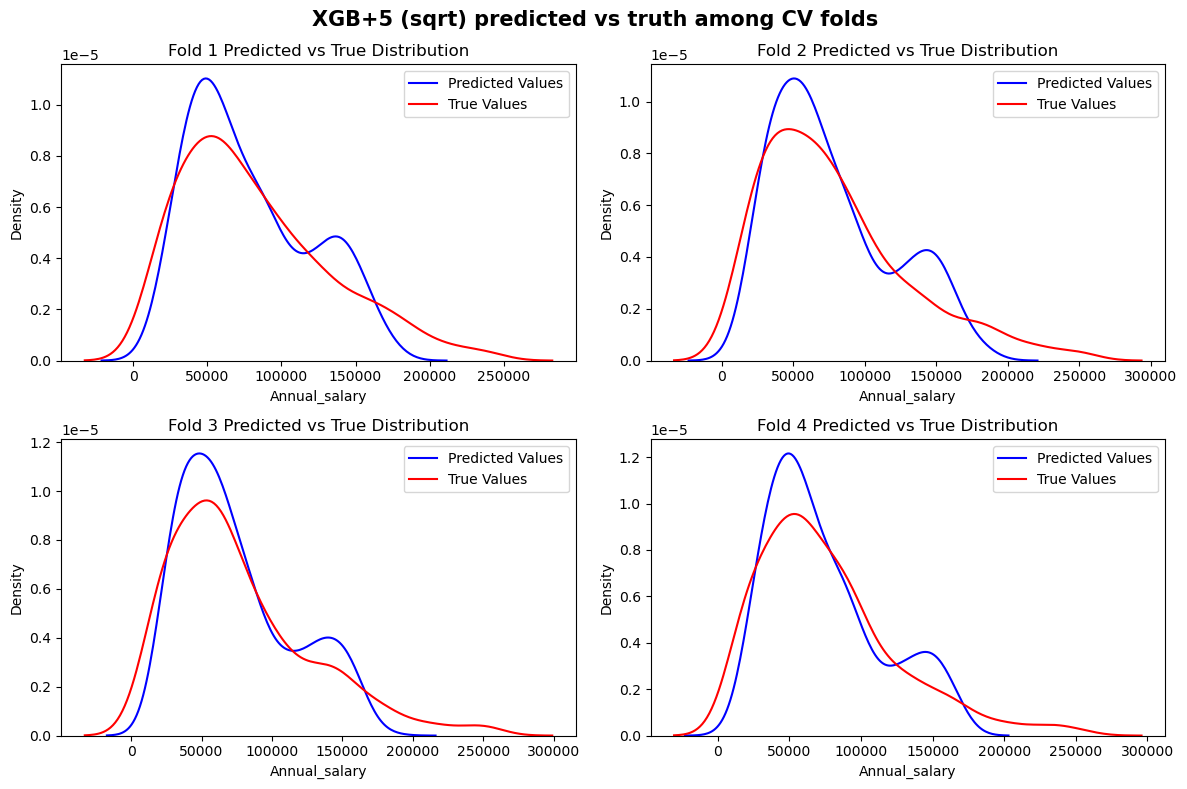

In [12]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.kdeplot(np.power(y_fold_pred,2), color='blue', label='Predicted Values')
    sns.kdeplot(np.power(y_fold_true,2), color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('XGB+5 (sqrt) predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [13]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train/Test set results


Train set metrics:
R^2: 0.7450061677478905
RMSE: 25395.733738077997
Adjusted R^2: 0.7327559976350326


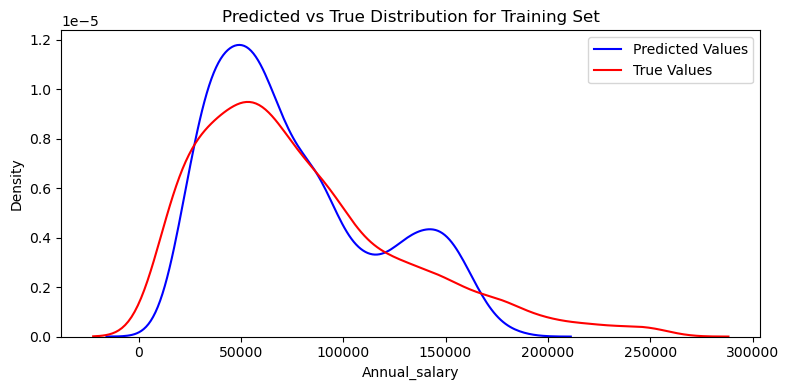

In [14]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")

y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_train_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_train,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6663663424212738
RMSE: 28612.29857821753
Adjusted R^2: 0.5896603898975934


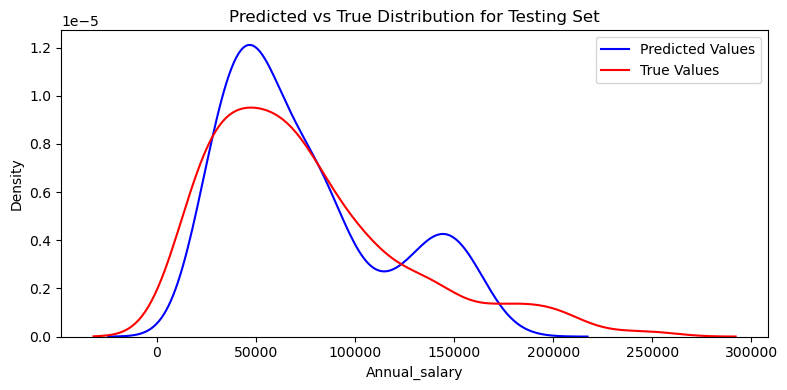

In [15]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")

y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(np.power(y_test_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_test,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

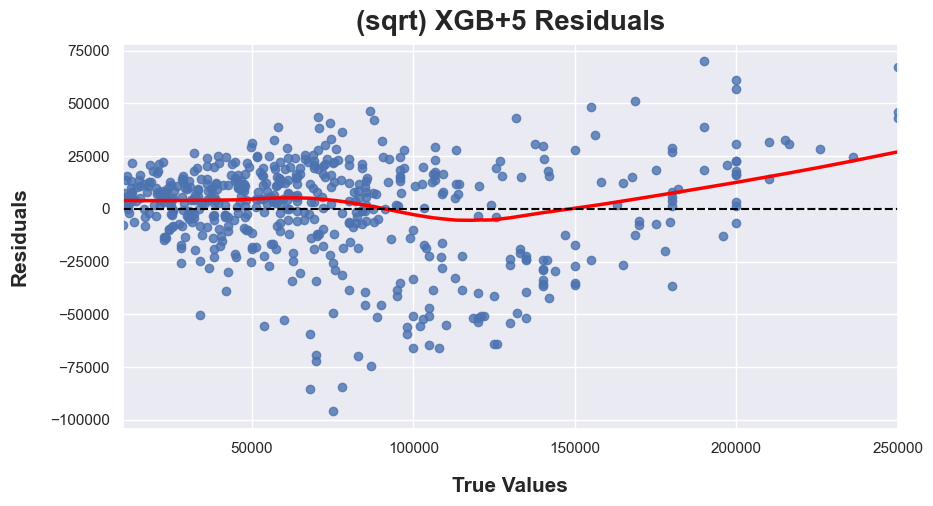

In [17]:
sns.set_theme(style='darkgrid')

residuals = np.power(y_test, 2) - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=np.power(y_test, 2), y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('(sqrt) XGB+5 Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-xgb+5-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 1000x600 with 0 Axes>

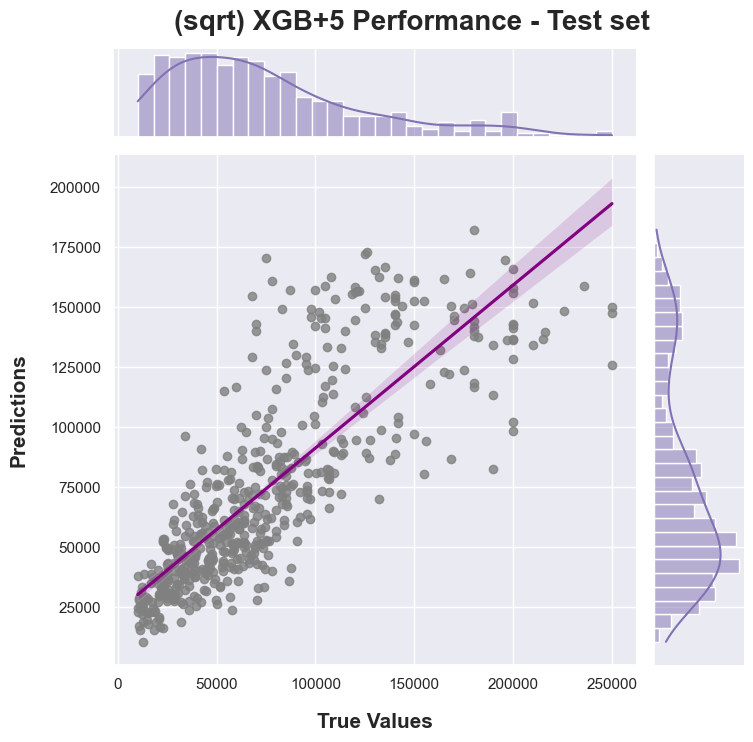

In [18]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) XGB+5 Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-xgb+5-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [19]:
df_cv_results.to_csv("../../output/sqrt-xgb+5-cv-results.csv")

Saving train and test sets predictions

In [20]:
np.savetxt("../../output/sqrt-xgb+5-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-xgb+5-test-predictions.csv", y_pred_test, delimiter=",")

## 7. Others

For XGB, let's also see the feature importance

### 7.1. Gain

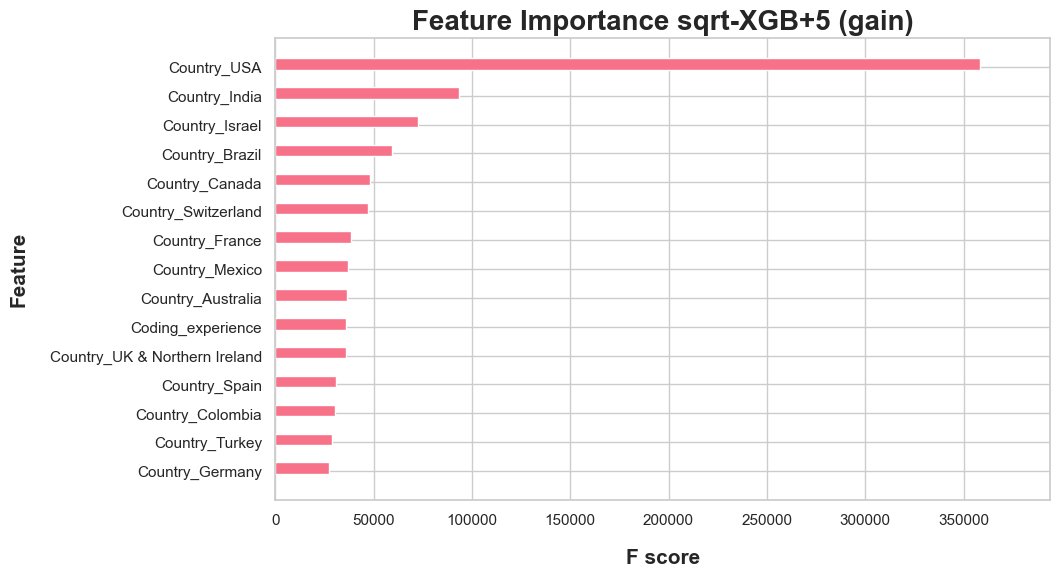

In [21]:
sns.set_theme(style='whitegrid', palette='husl') 

fig, ax = plt.subplots(figsize=(10, 6))

xgb.plot_importance(clf.best_estimator_, importance_type='gain', max_num_features=15, ax=ax, title='Gain Importance', show_values=False)

for bar in ax.patches:
    bar.set_height(bar.get_height() * 2)  # Multiplica el grosor de las barras por 2

# Ajusta los títulos y etiquetas
ax.set_title('Feature Importance sqrt-XGB+5 (gain)', weight='bold', fontsize=20)
ax.set_xlabel('F score', weight='bold', labelpad=15, fontsize=15)
ax.set_ylabel('Feature', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt+5-xgb-test-fscore-gain.pdf")
plt.show()

### 7.2. Weight

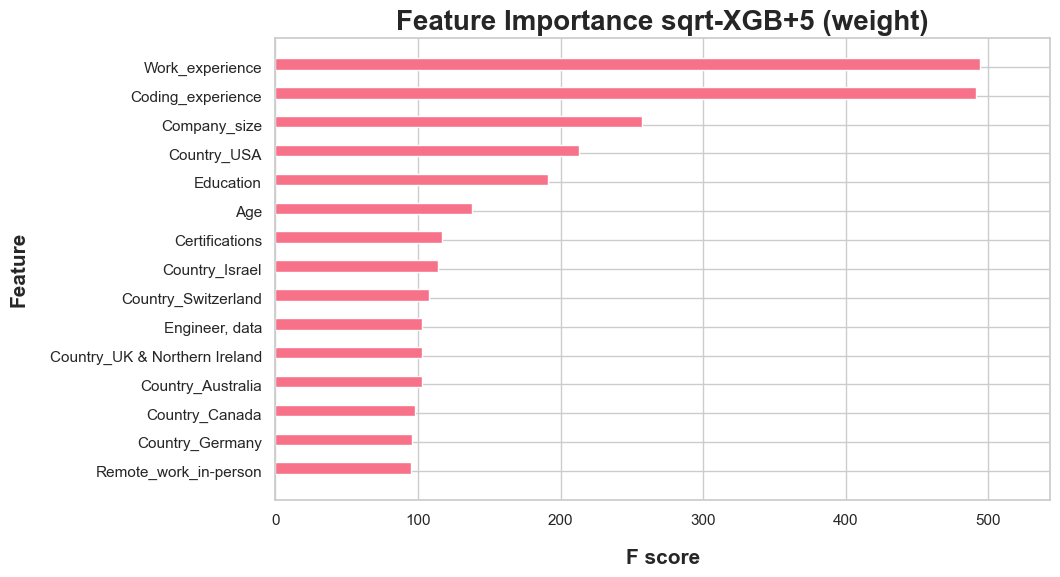

In [22]:
sns.set_theme(style='whitegrid', palette='husl') 

fig, ax = plt.subplots(figsize=(10, 6))

xgb.plot_importance(clf.best_estimator_, importance_type='weight', max_num_features=15, ax=ax, title='Gain Importance', show_values=False)

for bar in ax.patches:
    bar.set_height(bar.get_height() * 2)  # Multiplica el grosor de las barras por 2

# Ajusta los títulos y etiquetas
ax.set_title('Feature Importance sqrt-XGB+5 (weight)', weight='bold', fontsize=20)
ax.set_xlabel('F score', weight='bold', labelpad=15, fontsize=15)
ax.set_ylabel('Feature', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt+5-xgb-test-fscore-weight.pdf")

plt.show()


In [23]:
pd.set_option('display.max_colwidth', None)

df_cv_results[['params', 'mean_train_r2', 'mean_test_r2','mean_train_rmse', 'mean_test_rmse']]

,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'colsample_bytree': 0.6247240713084175, 'gamma': 1.9014286128198323, 'learning_rate': 0.0831993941811405, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 714, 'subsample': 0.6674996517121548}",0.688184,0.657771,28077.610563,29373.767976
1,"{'colsample_bytree': 0.45998494949080176, 'gamma': 0.9184977839317343, 'learning_rate': 0.04337086111390219, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 408, 'subsample': 0.9819459112971965}",0.726497,0.654241,26296.290112,29528.898395
2,"{'colsample_bytree': 0.899465584480253, 'gamma': 0.4246782213565523, 'learning_rate': 0.028182496720710062, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 559, 'subsample': 0.7669918962929685}",0.613719,0.600856,31251.031093,31721.298237
3,"{'colsample_bytree': 0.40423978313183045, 'gamma': 0.046124850082831514, 'learning_rate': 0.06247746602583892, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 575, 'subsample': 0.9842533113048755}",0.768374,0.661499,24198.694498,29217.512156
4,"{'colsample_bytree': 0.5396628042581826, 'gamma': 0.1812128690656416, 'learning_rate': 0.07183860093330872, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 931, 'subsample': 0.680057735948788}",0.834941,0.643584,20427.268285,29975.037218
5,"{'colsample_bytree': 0.9159642440417923, 'gamma': 1.3606150771755594, 'learning_rate': 0.05504992519695431, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 700, 'subsample': 0.9793792198447356}",0.724201,0.661520,26404.560650,29213.858291
6,"{'colsample_bytree': 0.8850384088698766, 'gamma': 0.6092275383467414, 'learning_rate': 0.01976721140063839, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 554, 'subsample': 0.7659979946695725}",0.708509,0.644612,27147.441782,29931.976661
7,"{'colsample_bytree': 0.8999169470416986, 'gamma': 0.34672930701554416, 'learning_rate': 0.049106060757324085, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 487, 'subsample': 0.5870266456536466}",0.713248,0.655095,26924.698620,29486.526538
8,"{'colsample_bytree': 0.7120408127066865, 'gamma': 1.0934205586865593, 'learning_rate': 0.028485445552552703, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 829, 'subsample': 0.6698524800218595}",0.759523,0.662039,24656.125994,29190.162912
9,"{'colsample_bytree': 0.6370901416010887, 'gamma': 1.8533177315875884, 'learning_rate': 0.08272719958564209, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 561, 'subsample': 0.5175897174514872}",0.806372,0.651560,22125.289765,29638.599961


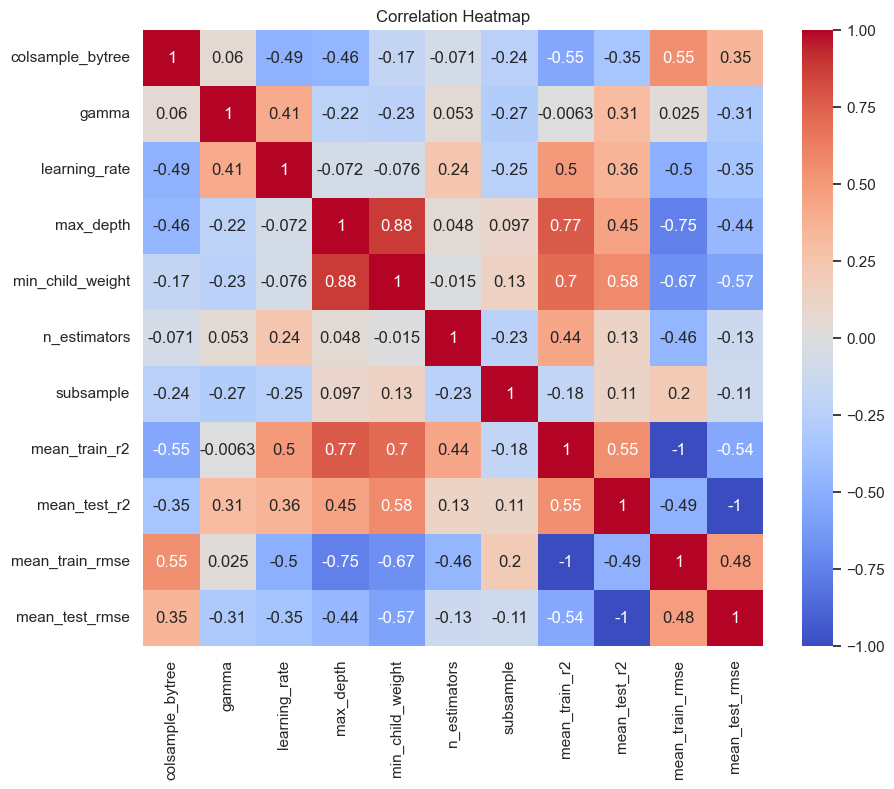

In [24]:
df_subset = df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

# Extraer las características de la columna 'params' en columnas individuales
params_df = df_subset['params'].apply(pd.Series)
df_processed = pd.concat([params_df, df_subset[['mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]], axis=1)

# Convertir valores de 'bootstrap' a números
# df_processed['bootstrap'] = df_processed['bootstrap'].astype(int)

# Calcular la correlación de Pearson
corr = df_processed.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [25]:
corr

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,subsample,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
colsample_bytree,1.000000,0.059796,-0.485996,-0.458433,-0.174017,-0.071164,-0.236424,-0.551502,-0.351440,0.548964,0.348762
gamma,0.059796,1.000000,0.412012,-0.220578,-0.228409,0.053024,-0.273632,-0.006260,0.307078,0.024662,-0.308530
learning_rate,-0.485996,0.412012,1.000000,-0.071705,-0.075666,0.240567,-0.245780,0.495215,0.355903,-0.503788,-0.354325
max_depth,-0.458433,-0.220578,-0.071705,1.000000,0.875000,0.047593,0.096967,0.770325,0.446217,-0.750328,-0.440848
min_child_weight,-0.174017,-0.228409,-0.075666,0.875000,1.000000,-0.015480,0.132883,0.704322,0.576627,-0.671890,-0.572747
n_estimators,-0.071164,0.053024,0.240567,0.047593,-0.015480,1.000000,-0.226994,0.435524,0.130340,-0.458964,-0.131130
subsample,-0.236424,-0.273632,-0.245780,0.096967,0.132883,-0.226994,1.000000,-0.180188,0.111917,0.202088,-0.113939
mean_train_r2,-0.551502,-0.006260,0.495215,0.770325,0.704322,0.435524,-0.180188,1.000000,0.547550,-0.997301,-0.542775
mean_test_r2,-0.351440,0.307078,0.355903,0.446217,0.576627,0.130340,0.111917,0.547550,1.000000,-0.488840,-0.999941
mean_train_rmse,0.548964,0.024662,-0.503788,-0.750328,-0.671890,-0.458964,0.202088,-0.997301,-0.488840,1.000000,0.483948
